In [3]:
import os
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from astropy.io import fits
import tensorflow as tf
from astropy.table import Table
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix
tf.config.threading.set_intra_op_parallelism_threads(16) # this limits the number of cores tensorflow can use
from astropy.cosmology import Planck15
import csv



'''
OUTPUTS:
    Figures:    # all within one file for that cnn run, together with CNN_conf_matrix_subhalos.csv (see below)
        CNN_*run_id*_history
        CNN_*run_id*_roc
        CNN_*run_id*_precision_recall
        CNN_*run_id*_confusion_matrix
    Info:
        CNN_runs_info.csv  ## Maybe have as one file for all runs and append each run
            CSV columns:
             - run ID
             - n-epochs
             - n-images
             - Image pixel scale
             - merger definition (i.e. thresholds for mass ratio, time since merger etc.)
             - Data splits
             - Model parameters
             - Stop training threshold
             - Training/ Validation Accuracy/Loss
         CNN_*run_id*_subhalo_labels.csv ## Some kind of csv for the true and predicted labels for each test subhalo
'''

def full_cnn_run(img_rs, labelList, n_epochs, run_id): # PLUS EXTRA PARAMS?
    
    # make directories and csv files
    path = '/home/AstroPhysics-Shared/PROJECTS/MPhys_Villforth/DATA/CNN_dir/CNN_run_%05d' %(run_id)
    if not os.path.exists(path):
        os.system('mkdir ' + path)
    #else:
        #`return print('File for run_id already exists')
    
    
    lab_trn, lab_val, lab_tst, tst_halos, img_trn, img_val, img_tst = split_imgs_labels(img_rs, labelList)

    ###AUGMENT IMAGES
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range = 10,       # deg--the edges will get streaky
        horizontal_flip = True,    
        vertical_flip = True,
        width_shift_range = 0.05,  # shift the centre up to 5% of image size
        height_shift_range = 0.05  
    )

    ###PARAMETERS FOR MODEL
    model = simple_cnn(
        img_rs[0].shape,                 # shape of input images
        n_labels=2,                      # number of labels
        verbose=True,                    # this is just whether to print the summary of the model
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=1e-3),         # Adam is the default choice, learning rate takes some experimentation
        loss='categorical_crossentropy', # measure of how different predictions and labels are
        metrics=['accuracy']             
    )

    # stop training early if the CNN is classifying better on the training set than the validation set
    val_stop_best = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',       # if validation loss fails to decrease
        patience=10,              # for more than 10 epochs 
        restore_best_weights=True)# cut off training and restore the weights from the epoch w/lowest validation loss


    #TRAINING
    hist = model.fit(                                    # returns the model history to look at
        datagen.flow(img_trn, lab_trn, batch_size=32),   # pesky generators...
        steps_per_epoch=len(img_trn)/32,                 # batch_size * steps_per_epoch = n_img
        epochs=n_epochs,                                 # defined above, max number epochs
        validation_data=(img_val, lab_val),              # validation images and labels
        callbacks=[val_stop_best],                       # early stopping
        verbose=1) 


    # PLOT TRAINING HISTORY
    fig = plt.figure(figsize=(15,10))
    gs = fig.add_gridspec(nrows=2, ncols=1, hspace=0)
    axs = [fig.add_subplot(gs[0,0]), fig.add_subplot(gs[1,0])]
    # axs = fig.subplots(nrows=2, ncols=1)

    acc = hist.history['accuracy']
    loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']

    axs[0].plot(range(1,len(acc)+1), acc, c='k', zorder=5)
    axs[1].plot(range(1,len(loss)+1), loss, c='k', zorder=5,
                label='Training')
    axs[0].plot(range(1,len(val_acc)+1), val_acc, c='b', zorder=6)
    axs[1].plot(range(1,len(val_loss)+1), val_loss, c='b', zorder=6,
                label='Validation')

    axs[0].tick_params(labeltop=True)
    axs[-1].set_xlabel('Epoch', size=20)
    axs[0].set_ylabel('Accuracy', size=20)
    axs[1].set_ylabel('Loss', size=20)

    axs[1].legend(loc='upper left', fontsize=20).set_zorder(7)
    for ax in axs:
        ax.set_ylim(*ax.get_ylim())
        ax.plot((len(acc)-10)*np.ones(2), ax.get_ylim(), c='r', zorder=3)
        ax.set_xticks(range(0,len(acc)+10, 10))
        ax.set_xlim(-1, len(acc)+1)
        ax.tick_params(labelsize=14, direction='in', right=True, top=True, labelright=True)
        ax.spines['top'].set_zorder(8)
        ax.grid(True, zorder=1)

    # SAVE TRAINING HISTORY
    fig.savefig('/home/AstroPhysics-Shared/PROJECTS/MPhys_Villforth/DATA/CNN_dir/CNN_run_%05d/CNN_run_%05d_history.jpg' %(run_id, run_id))


    # Add these to CSV
    tra_acc = acc[np.argmin(val_loss)]
    val_acc = val_acc[np.argmin(val_loss)]
    tra_loss = loss[np.argmin(val_loss)]
    val_loss = val_loss[np.argmin(val_loss)]
    
    p_trn = model.predict(img_trn)[:,1] # converting back from the one-hot encoding
    p_val = model.predict(img_val)[:,1]
    p_tst = model.predict(img_tst)[:,1]

    lab_trn = lab_trn[:,1]
    lab_val = lab_val[:,1]
    lab_tst = lab_tst[:,1]

    # GENERATE ROC CURVE
    fig = plt.figure(figsize=(5,5))
    ax = fig.subplots(nrows=1, ncols=1)

    thresholds = np.linspace(0,1,num=1000)
    for pred, lab, c, ls, z, name in zip([p_trn,      p_val,        p_tst],   # predictions
                                         [lab_trn,    lab_val,      lab_tst], # labels
                                         ['darkcyan', 'orange',     'red'],   # colours
                                         [':',        '-',          '--'],    # linestyles
                                         [5,           3,           4],      # zorder...
                                         ['Training', 'Validation', 'Testing']):   

        tpr = np.array([np.sum(np.logical_and(pred > th, lab == 1)) for th in thresholds])/np.sum(lab)
        fpr = np.array([np.sum(np.logical_and(pred > th, lab == 0)) for th in thresholds])/(len(lab) - np.sum(lab))

        ax.plot(fpr, tpr, c=c, ls=ls, zorder=z, label=name)

    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.set_xlabel('FPR')
    ax.set_ylabel('TPR')
    ax.grid(True, zorder=1)
    ax.legend(loc=4)

    # SAVE ROC CURVE
    fig.savefig('/home/AstroPhysics-Shared/PROJECTS/MPhys_Villforth/DATA/CNN_dir/CNN_run_%05d/CNN_run_%05d_ROC.jpg' %(run_id, run_id))



    dist = np.sqrt(fpr**2 + (tpr-1)**2)
    th_opt = thresholds[np.argmin(dist)] # Output this to CSV


    # GENERATE PRECISION RECALL CURVE
    fig = plt.figure(figsize=(5,5))
    axp = fig.subplots(nrows=1, ncols=1)
    axr = axp.twinx()

    for pred, lab, c, ls, z, name in zip([p_trn,      p_val,        p_tst],   # predictions
                                         [lab_trn,    lab_val,      lab_tst], # labels
                                         ['darkcyan', 'orange',     'red'],   # colours
                                         [':',        '-',          '--'],    # linestyles
                                         [5,           3,           4],       # zorder...
                                         ['Training', 'Validation', 'Testing']):   

        prec = np.array([np.sum(np.logical_and(pred > th, lab == 1))/np.sum(pred > th) for th in thresholds])
        rec  = np.array([np.sum(np.logical_and(pred > th, lab == 1)) for th in thresholds])/np.sum(lab)

        axp.plot(thresholds, prec, c=c, ls=ls, zorder=z, label=name)
        axr.plot(thresholds, rec,  c=c, ls=ls, zorder=z, label=name)

    axp.set_xlim(0,1)
    axp.set_ylim(0,1)
    axr.set_ylim(0,1)
    axp.set_xlabel('Threshold')
    axp.set_ylabel('Precision')
    axr.set_ylabel('Recall', rotation=270, va='baseline')

    axp.grid(True, zorder=1)

    fig.savefig('/home/AstroPhysics-Shared/PROJECTS/MPhys_Villforth/DATA/CNN_dir/CNN_run_%05d/CNN_run_%05d_precision_recall.jpg' %(run_id, run_id))

    f1 = 2*prec*rec/(prec+rec)
    th_opt_f1 = thresholds[np.nanargmax(f1)] # OUTPUT THIS TO CSV


    # GENERATE CONFUSION MATRIX
    conf_matrix = confusion_matrix(lab_tst, (p_tst > th_opt).astype(int), normalize='true')

    fig = plt.figure(figsize=(4,4))
    ax = fig.subplots(nrows=1, ncols=1)
    ax.imshow(conf_matrix, cmap='Blues')
    for x,y in np.ndindex((2,2)):
        ax.text(x, y, '%.3f' %conf_matrix[y,x], 
                c=np.ones(3)*int(conf_matrix[y,x] > 0.5), ha='center', va='center', size=16)

    ax.set_xlabel('Predicted label', size=16)
    ax.set_xticks(ticks=range(2),
                  labels=['nonmerger', 'merger'])
    ax.set_ylabel('Predicted label', size=16)
    ax.set_yticks(ticks=range(2),
                  labels=['nonmerger', 'merger'],
                  rotation=90, va='center')
    ax.tick_params(labelsize=16)

    ## SAVE CONF MATRIX
    fig.savefig('/home/AstroPhysics-Shared/PROJECTS/MPhys_Villforth/DATA/CNN_dir/CNN_run_%05d/CNN_run_%05d_conf_matrix.jpg' %(run_id, run_id))
    
    
    ## MAKE CSV AND WRITE SUBHALO INFO
    csv_name = '/home/AstroPhysics-Shared/PROJECTS/MPhys_Villforth/DATA/CNN_dir/CNN_run_%05d/CNN_run_%05d_subhalo_labels.csv' %(run_id, run_id)

    with open(csv_name, 'w', encoding='UTF8') as f:
        writer = csv.writer(f)

        # write the header
        header = ['SFID', 'SNAP', 'LABEL', 'PRED_LABEL']
        writer.writerow(header)
        for i in range(len(tst_halos[0,:])):
            # write the data
            data = [tst_halos[0,i], tst_halos[0,i], lab_tst[i], p_tst[i]]
            writer.writerow(data)
    
    

#function to import available images given a grab_list and directory
def AvailableDF(grab_filepath, img_path, img_format='.fits'):
    '''
    Takes a grablist and an an image directory and returns a dataframe of which images are available for use with all parameters included
    '''
    imgList = sorted(list(glob(img_path+'*'+img_format)))
    grab_list = pd.read_parquet(grab_filepath)
    grab_list['Available'] = False
    for img in imgList:
        path, file = os.path.split(img)
        SFIDandSNAP = file.replace('SFID_','').replace('_SNAP','').replace('.fits','')
        split = SFIDandSNAP.split('_') #split = [SFID,snap]
        if len(grab_list.loc[(grab_list['SFID'] == int(split[0])) & (grab_list['SnapNum'] == int(split[1]))]) > 0:
            grab_list.loc[(grab_list['SFID'] == int(split[0])) & (grab_list['SnapNum'] == int(split[1])), 'Available'] = True

    #dataframe of all available objects including flags redshift
    available_df = grab_list[grab_list['Available']]
    return available_df


#crop, rebin, and rescale image
def rescale_img_and_size(img, hdr, band, i, new_size=50):
    '''
    crop one image file (one view, one band), down to 10HMRad and rescale the pixels to be constant for the CNN
    inputs
    img: the image file
    hdr: the image header, stores metadata
    band: the band of the image matters as the pixel scale is different in this band
    i: the index of the image in the available_df, used to find HMRad
    new_size: the pixel width and height of the new image
    returns
    the cropped and rescaled and rebinned image
    '''
    img = np.moveaxis([img], 0, 2)
    old_size = len(img[0])
    pixels= old_size/1.5 
    
    lower = int((old_size - pixels) / 2)
    upper = int(lower+pixels)
    
    img[np.isneginf(img)] = np.nanmin(img[np.isfinite(img)])
    img[np.isposinf(img)] = np.nanmax(img[np.isfinite(img)])
    img = (img - np.nanmin(img))/(np.nanmax(img) - np.nanmin(img))
    img = 1. - img
    img = np.array(tf.image.resize(img[lower:upper, lower:upper], [new_size, new_size]))
    img[np.isneginf(img)] = np.nanmin(img[np.isfinite(img)])
    img[np.isposinf(img)] = np.nanmax(img[np.isfinite(img)])
    img = (img - np.nanmin(img))/(np.nanmax(img) - np.nanmin(img))
#     img = 1. - img
    return img

def check_inf(img):
    img = img.flatten()
    for i in range(np.size(img)):
        if np.isnan(img[i]):
            return 1
        if np.isinf(img[i]):
            return 1
    return 0
              

def simple_cnn(input_shape, n_labels=2, verbose=True, optimizer='adam', 
               loss='categorical_crossentropy', metrics=['accuracy']):
    model = tf.keras.Sequential()
    
    # Adding convolutional layers
    model.add(tf.keras.layers.Conv2D(32, (3,3), input_shape=input_shape, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization()) # double check axis
    model.add(tf.keras.layers.MaxPooling2D())
    model.add(tf.keras.layers.Dropout(0.1))
    
    model.add(tf.keras.layers.Conv2D(64, (3,3), input_shape=input_shape, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization()) # double check axis
    model.add(tf.keras.layers.MaxPooling2D())
    model.add(tf.keras.layers.Dropout(0.1))

    model.add(tf.keras.layers.Conv2D(128, (3,3), input_shape=input_shape, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization()) # double check axis
    model.add(tf.keras.layers.MaxPooling2D())
    model.add(tf.keras.layers.Dropout(0.1))
        
    # Adding other layers
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dense(n_labels, activation='softmax'))
    
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    if verbose:
        print(model.summary())
        
    return model


    #GETTING IMAGES, RESCALING AND REBINNING, FIXING A FULL LIST OF LABELS
    #IMAGES ARE GROUPED INTO 1axes(3bands) * 3 per object
def img_rs_and_labels(img_halos, img_labels, img_dir, img_fmt,  n_bands = 3, band_no = 1, new_size = 50):
    
    imgs_rs=[]
    imgs=[]
    label_list = []
    
    # for i in range(len(img_halos[0,:])):
    for i in range(1000):

        with fits.open(img_dir + img_fmt%(img_halos[0,i],img_halos[1,i])) as hdul:
            this_img = []
            hdr = hdul[0].header
        #     print(hdr)

            if n_bands == 3:
                band_idxs=[1, 2, 3]
                band_no = 0
            if n_bands == 1:
                band_idxs = [band_no]

            for band_idx in band_idxs:
                band = hdul[band_idx]
                for ax in [0,1,2]:

                    this_img.append(rescale_img_and_size(band.data[ax], hdr, band_no, i, new_size=new_size))
                

            #   reorganising images by axes, then adding merger labels to the label_list

            label = img_labels[i]

            if (n_bands == 1):
                imgs_rs.append([this_img[0],this_img[1],this_img[2]])
                label_list.extend([[label,img_halos[0,i], img_halos[1,i]]])

            else:
                imgs_rs.append([this_img[0],this_img[3],this_img[6]])
                imgs_rs.append([this_img[1],this_img[4],this_img[7]])
                imgs_rs.append([this_img[2],this_img[5],this_img[8]])
                label_list.extend([[label,img_halos[0,i], img_halos[1,i]], 
                                    [label,img_halos[0,i], img_halos[1,i]], 
                                    [label,img_halos[0,i], img_halos[1,i]]]) # Preserves subhalo information

        if i%100==0:
            print('images rebinned, split by band, grouped by axes', i)
    
    label_list = np.array(label_list)
    img_list = np.moveaxis(np.array(imgs_rs),1,3)[:, :, :, :, 0]#rearrange axis then deal with shape issue with slices at the end
    return img_list, label_list


def split_imgs_labels(img_list, label_list, test_size_trn = 0.2, test_size_val = 0.5):
    
    skf = StratifiedShuffleSplit(n_splits=1, test_size=test_size_trn, random_state=42)
    
    for trn_idx, oth_idx in skf.split(img_list, label_list[:,0]): # written this way because generator
        print(trn_idx.shape, oth_idx.shape)
        img_trn, img_oth = img_list[trn_idx], img_list[oth_idx]
        lab_trn, lab_oth = label_list[trn_idx], label_list[oth_idx]


    # separate again validation and testing
    skf = StratifiedShuffleSplit(n_splits=1, test_size=test_size_val, random_state=42)
    for val_idx, tst_idx in skf.split(img_oth, lab_oth[:,0]): 
        img_val, img_tst = img_list[val_idx][:], img_list[tst_idx][:]
        lab_val, lab_tst = label_list[val_idx], label_list[tst_idx]


    lab_trn = tf.keras.utils.to_categorical(lab_trn[:,0]) # one-hot labels
    lab_val = tf.keras.utils.to_categorical(lab_val[:,0])

    tst_halos = np.array([lab_tst[:,1], lab_tst[:,2]])
    lab_tst = tf.keras.utils.to_categorical(lab_tst[:,0])
                   
    return lab_trn, lab_val, lab_tst, tst_halos, img_trn, img_val, img_tst

2022-11-10 15:21:45.121850: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-10 15:21:45.321566: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/ansys_inc/v181/Framework/bin/Linux64/Mesa:
2022-11-10 15:21:45.321590: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-10 15:21:45.348912: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been

In [2]:
#function to import available images given a grab_list and directory
def AvailableDF(grab_filepath, img_path, img_format='.fits'):
    '''
    Takes a grablist and an an image directory and returns a dataframe of which images are available for use with all parameters included
    '''
    imgList = sorted(list(glob(img_path+'*'+img_format)))
    grab_list = pd.read_parquet(grab_filepath)
    grab_list['Available'] = False
    for img in imgList:
        path, file = os.path.split(img)
        SFIDandSNAP = file.replace('SFID_','').replace('_SNAP','').replace('.fits','')
        split = SFIDandSNAP.split('_') #split = [SFID,snap]
        if len(grab_list.loc[(grab_list['SFID'] == int(split[0])) & (grab_list['SnapNum'] == int(split[1]))]) > 0:
            grab_list.loc[(grab_list['SFID'] == int(split[0])) & (grab_list['SnapNum'] == int(split[1])), 'Available'] = True

    #dataframe of all available objects including flags redshift
    available_df = grab_list[grab_list['Available']]
    return available_df

#rescale image values
def rescale_img(img):
#     img = np.moveaxis(img, 0, 2)
    img[np.isneginf(img)] = np.nanmin(img[np.isfinite(img)])
    img[np.isposinf(img)] = np.nanmax(img[np.isfinite(img)])
    img = (img - np.nanmin(img))/(np.nanmax(img) - np.nanmin(img))
    img = 1. - img
    return img

#crop, rebin, and rescale image
def rescale_img_and_size(img, hdr, band, i, new_size=50):
    '''
    crop one image file (one view, one band), down to 10HMRad and rescale the pixels to be constant for the CNN
    inputs
    img: the image file
    hdr: the image header, stores metadata
    band: the band of the image matters as the pixel scale is different in this band
    i: the index of the image in the available_df, used to find HMRad
    new_size: the pixel width and height of the new image
    returns
    the cropped and rescaled and rebinned image
    '''
    img = np.moveaxis([img], 0, 2)
    old_size = len(img[0])
    pixels= old_size/1.5 
    
    lower = int((old_size - pixels) / 2)
    upper = int(lower+pixels)
    
    img[np.isneginf(img)] = np.nanmin(img[np.isfinite(img)])
    img[np.isposinf(img)] = np.nanmax(img[np.isfinite(img)])
    img = (img - np.nanmin(img))/(np.nanmax(img) - np.nanmin(img))
    img = 1. - img
    img = np.array(tf.image.resize(img[lower:upper, lower:upper], [new_size, new_size]))
    img[np.isneginf(img)] = np.nanmin(img[np.isfinite(img)])
    img[np.isposinf(img)] = np.nanmax(img[np.isfinite(img)])
    img = (img - np.nanmin(img))/(np.nanmax(img) - np.nanmin(img))
#     img = 1. - img
    return img

def check_inf(img):
    img = img.flatten()
    for i in range(np.size(img)):
        if np.isnan(img[i]):
            return 1
        if np.isinf(img[i]):
            return 1
    return 0

def image_resized_list(img,i,img_list,label_list):
    '''
    resize all bands and axes of an image and append them to a list
    input: image of interest
    img_list: list to append the images to
    label_list: lsit to append the True/False merger labels to
    '''
    label = available_df.loc[i,'MergerFlag']

    with fits.open(img) as hdul:#img should look like (img_dir + img_fmt%(img_sfids[i],img_snaps[i]))
        hdr = hdul[0].header
    #     print(hdr)
        imgs_rs=[]
        imgs=[]
        band_no=0
        for band in hdul[1:]:
            for ax in [0,1,2]:
                img_list.append(rescale_img_and_size(band.data[ax], hdr, band_no, i, new_size=50))
                label_list.append(label)
            band_no+=1
              

def all_rs_img_and_labels(img_sfids, img_snaps):
    '''
    make a list of images (all bands and axes separately stored), and corresponding labels
    '''
    img_list = []
    label_list = []
    for i in range(len(img_sfids)):
        img = (img_dir + img_fmt%(img_sfids[i],img_snaps[i]))
#         image_resized_list(img,i,img_list,label_list)
        with fits.open(img) as hdul:#img should look like (img_dir + img_fmt%(img_sfids[i],img_snaps[i]))
            hdr = hdul[0].header
        #     print(hdr)
            imgs_rs=[]
            imgs=[]
            band_no=0
            for band in hdul[1:]:
                for ax in [0,1,2]:
                    img_list.append(rescale_img_and_size(band.data[ax], hdr, band_no, i, new_size=50))
                    label_list.append(label)
                band_no+=1
        if i%100==0:
            print('images rebinned ',i)
        
    return img_list, label_list

def simple_cnn(input_shape, n_labels=2, verbose=True, optimizer='adam', 
               loss='categorical_crossentropy', metrics=['accuracy']):
    model = tf.keras.Sequential()
    
    # Adding convolutional layers
    model.add(tf.keras.layers.Conv2D(32, (3,3), input_shape=input_shape, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization()) # double check axis
    model.add(tf.keras.layers.MaxPooling2D())
    model.add(tf.keras.layers.Dropout(0.1))
    
    model.add(tf.keras.layers.Conv2D(64, (3,3), input_shape=input_shape, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization()) # double check axis
    model.add(tf.keras.layers.MaxPooling2D())
    model.add(tf.keras.layers.Dropout(0.1))

    model.add(tf.keras.layers.Conv2D(128, (3,3), input_shape=input_shape, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization()) # double check axis
    model.add(tf.keras.layers.MaxPooling2D())
    model.add(tf.keras.layers.Dropout(0.1))
        
    # Adding other layers
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dense(n_labels, activation='softmax'))
    
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    if verbose:
        print(model.summary())
        
    return model



2022-11-10 15:22:32.185697: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2022-11-10 15:22:32.185738: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (py-noether): /proc/driver/nvidia/version does not exist
2022-11-10 15:22:32.186233: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


images rebinned, split by band, grouped by axes 0
images rebinned, split by band, grouped by axes 100
images rebinned, split by band, grouped by axes 200
images rebinned, split by band, grouped by axes 300
images rebinned, split by band, grouped by axes 400
images rebinned, split by band, grouped by axes 500
images rebinned, split by band, grouped by axes 600
images rebinned, split by band, grouped by axes 700
images rebinned, split by band, grouped by axes 800
images rebinned, split by band, grouped by axes 900
(2400,) (600,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 32)       128       
 ormalization)                                                   
                                                   

/opt/anaconda3/envs/astroconda3/lib/python3.7/site-packages/ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in long_scalars


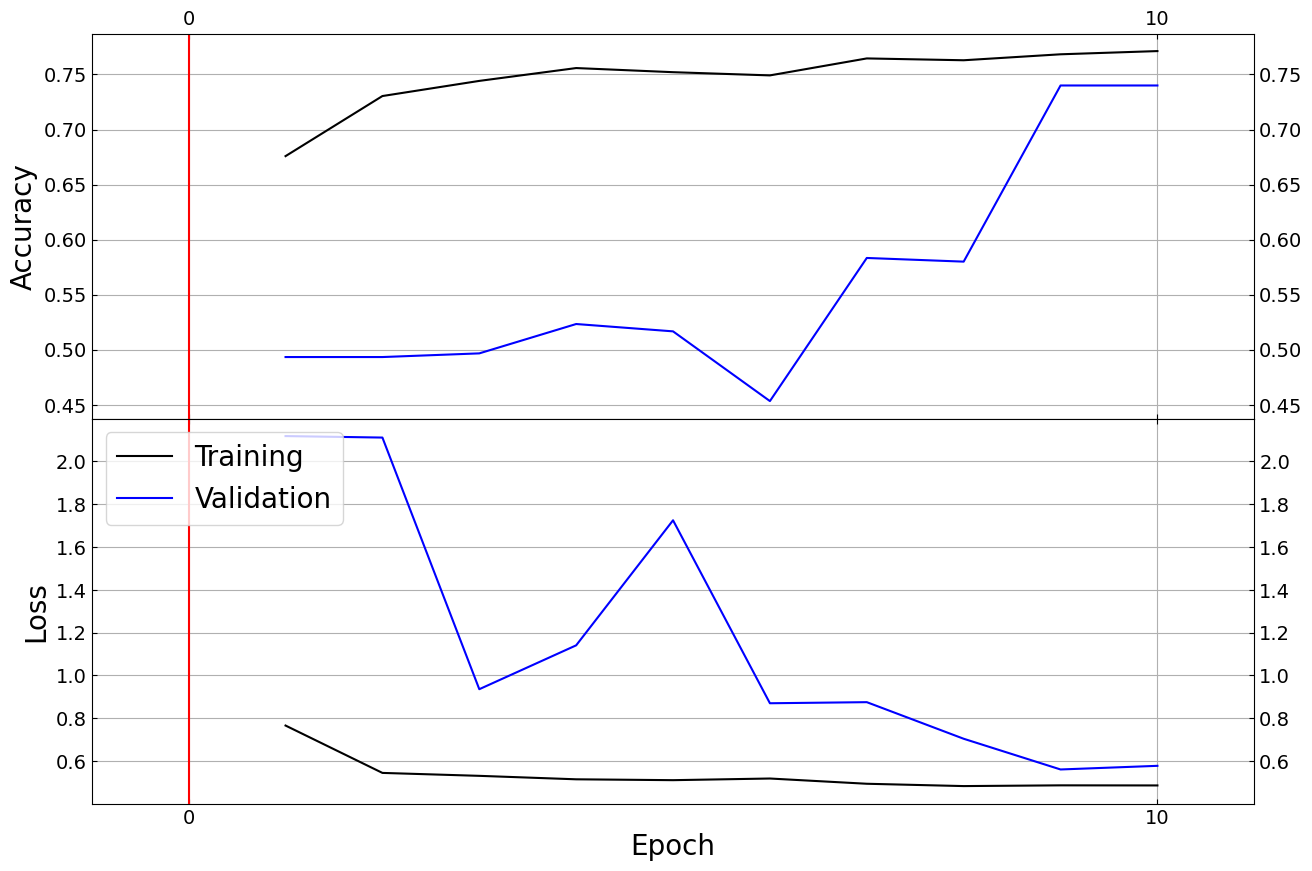

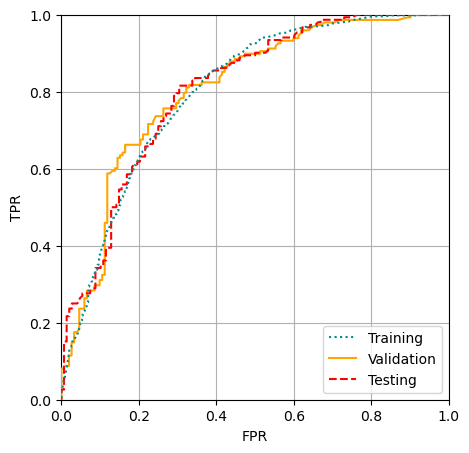

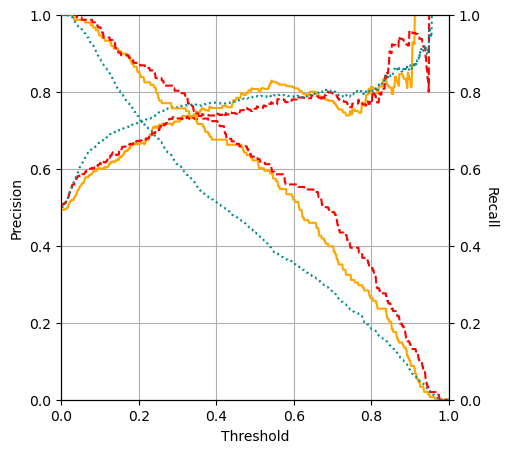

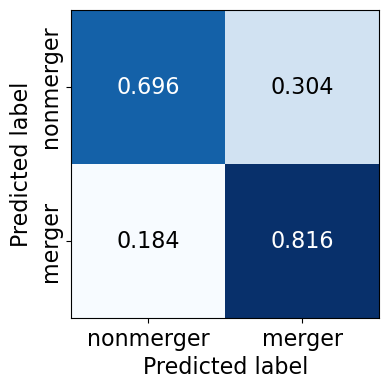

In [4]:
### RUN BEGINS ###


##paths and image formats
real_path = '/home/AstroPhysics-Shared/PROJECTS/MPhys_Villforth/DATA/IMG_dir/REAL_FITS_11_04v2_dir/'
grab_filepath = '/home/AstroPhysics-Shared/PROJECTS/MPhys_Villforth/DATA/DF_dir/grablist_11_04v2.parquet'
img_dir = '/home/AstroPhysics-Shared/PROJECTS/MPhys_Villforth/DATA/IMG_dir/REAL_FITS_11_04v2_dir/'
img_fmt = 'SFID_%07d_SNAP_%02d.fits'

available_df = AvailableDF(grab_filepath, real_path) # Pull df of suitable subhalos

available_df=available_df.reset_index()

img_halos = np.array([available_df['SFID'], available_df['SnapNum']]) # Subhalos and snap nums
img_labels = available_df['MergerFlag'] # Merger flags

img_rs, labelList = img_rs_and_labels(img_halos, img_labels, img_dir, img_fmt, new_size = 50) # Rescale images and generate label list

run_id = 0
n_epochs = 10

full_cnn_run(img_rs, labelList, n_epochs, run_id)

### END OF RUN ###

In [4]:
available_df = AvailableDF(grab_filepath, real_path)

available_df=available_df.reset_index()
img_halos = np.array([available_df['SFID'], available_df['SnapNum']])
img_labels = available_df['MergerFlag']

In [5]:
img_dir = '/home/AstroPhysics-Shared/PROJECTS/MPhys_Villforth/DATA/IMG_dir/REAL_FITS_11_04v2_dir/'
img_fmt = 'SFID_%07d_SNAP_%02d.fits'

In [6]:
def img_rs_and_labels(img_halos, img_labels, n_bands, band_no = 1):
    
    imgs_rs=[]
    imgs=[]
    label_list = []
    for i in range(500):

        with fits.open(img_dir + img_fmt%(img_halos[0,i],img_halos[1,i])) as hdul:
            this_img = []
            hdr = hdul[0].header
        #     print(hdr)

            if n_bands == 3:
                band_idxs=[1, 2, 3]
                band_no = 0
            if n_bands == 1:
                band_idxs = [band_no]

            for band_idx in band_idxs:
                band = hdul[band_idx]
                for ax in [0,1,2]:

                    this_img.append(rescale_img_and_size(band.data[ax], hdr, band_no, i, new_size=50))
                

            #   reorganising images by axes, then adding merger labels to the label_list

            label = available_df.loc[i,'MergerFlag']

            if (n_bands == 1):
                imgs_rs.append([this_img[0],this_img[1],this_img[2]])
                label_list.extend([[label,img_halos[0,i], img_halos[1,i]]])

            else:
                imgs_rs.append([this_img[0],this_img[3],this_img[6]])
                imgs_rs.append([this_img[1],this_img[4],this_img[7]])
                imgs_rs.append([this_img[2],this_img[5],this_img[8]])
                label_list.extend([[label,img_halos[0,i], img_halos[1,i]], 
                                    [label,img_halos[0,i], img_halos[1,i]], 
                                    [label,img_halos[0,i], img_halos[1,i]]]) # Preserves subhalo information

        if i%100==0:
            print('images rebinned, split by band, grouped by axes', i)
        print(i, len(imgs_rs), len(label_list))
    
    label_list = np.array(label_list)
    img_list = np.moveaxis(np.array(imgs_rs),1,3)[:, :, :, :, 0]#rearrange axis then deal with shape issue with slices at the end
    return img_list, label_list

img_rs, label_list = img_rs_and_labels(img_halos, img_labels, n_bands = 3)

2022-11-10 14:31:12.534431: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2022-11-10 14:31:12.534475: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (py-noether): /proc/driver/nvidia/version does not exist
2022-11-10 14:31:12.534977: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


images rebinned, split by band, grouped by axes 0
0 3 3
1 6 6
2 9 9
3 12 12
4 15 15
5 18 18
6 21 21
7 24 24
8 27 27
9 30 30
10 33 33
11 36 36
12 39 39
13 42 42
14 45 45
15 48 48
16 51 51
17 54 54
18 57 57
19 60 60
20 63 63
21 66 66
22 69 69
23 72 72
24 75 75
25 78 78
26 81 81
27 84 84
28 87 87
29 90 90
30 93 93
31 96 96
32 99 99
33 102 102
34 105 105
35 108 108
36 111 111
37 114 114
38 117 117
39 120 120
40 123 123
41 126 126
42 129 129
43 132 132
44 135 135
45 138 138
46 141 141
47 144 144
48 147 147
49 150 150
50 153 153
51 156 156
52 159 159
53 162 162
54 165 165
55 168 168
56 171 171
57 174 174
58 177 177
59 180 180
60 183 183
61 186 186
62 189 189
63 192 192
64 195 195
65 198 198
66 201 201
67 204 204
68 207 207
69 210 210
70 213 213
71 216 216
72 219 219
73 222 222
74 225 225
75 228 228
76 231 231
77 234 234
78 237 237
79 240 240
80 243 243
81 246 246
82 249 249
83 252 252
84 255 255
85 258 258
86 261 261
87 264 264
88 267 267
89 270 270
90 273 273
91 276 276
92 279 279
93 282 28

In [40]:
print(np.array(img_rs)[:,:,:,:,0].shape)
print(np.moveaxis(np.array(imgs_rs),1,3)[:, :, :, :, :].shape)
print(np.moveaxis(np.array(imgs_rs),1,3)[:, :, :, :, :])

(1500, 3, 50, 50)
(1503, 50, 50, 3, 1)
[[[[[0.1099061 ]
    [0.10677774]
    [0.18720084]]

   [[0.05485684]
    [0.07487664]
    [0.19583598]]

   [[0.0797993 ]
    [0.06336726]
    [0.1618163 ]]

   ...

   [[0.11960476]
    [0.09497891]
    [0.17524105]]

   [[0.05286964]
    [0.10243555]
    [0.17446238]]

   [[0.06411288]
    [0.        ]
    [0.19213003]]]


  [[[0.0350387 ]
    [0.10140376]
    [0.2128341 ]]

   [[0.10211296]
    [0.10412806]
    [0.22189893]]

   [[0.0774406 ]
    [0.09810554]
    [0.24837916]]

   ...

   [[0.04435185]
    [0.10465647]
    [0.1578434 ]]

   [[0.08287436]
    [0.13334636]
    [0.20909318]]

   [[0.05472066]
    [0.09563749]
    [0.19101979]]]


  [[[0.06390722]
    [0.12045254]
    [0.20625804]]

   [[0.07054981]
    [0.09941879]
    [0.2535826 ]]

   [[0.05360832]
    [0.09156387]
    [0.20745224]]

   ...

   [[0.06146076]
    [0.12259557]
    [0.19326012]]

   [[0.06378172]
    [0.08561897]
    [0.17493176]]

   [[0.10894423]
    [0.12246802

In [18]:
label_list = np.array(label_list)
img_list = np.moveaxis(np.array(imgs_rs),1,3)[:, :, :, :, 0]#rearrange axis then deal with shape issue with slices at the end

In [19]:
print(img_rs.shape)

(1500, 50, 50, 3)


In [7]:
skf = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

In [8]:
for trn_idx, oth_idx in skf.split(img_rs, label_list[:,0]): # written this way because generator
#     print(trn_idx, oth_idx)
    img_trn, img_oth = img_rs[trn_idx], img_rs[oth_idx]
    lab_trn, lab_oth = label_list[trn_idx], label_list[oth_idx]
print(lab_trn)

[[     1     82     40]
 [     1 395317     41]
 [     0  28822     28]
 ...
 [     1 270583     36]
 [     1 269130     44]
 [     0 263172     47]]


In [10]:
# separate again validation and testing
skf = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
for val_idx, tst_idx in skf.split(img_oth, lab_oth[:,0]): 
    img_val, img_tst = img_rs[val_idx][:], img_rs[tst_idx][:]
    lab_val, lab_tst = label_list[val_idx], label_list[tst_idx]

In [40]:
lab_trn = tf.keras.utils.to_categorical(lab_trn[:,0]) # one-hot labels
lab_val = tf.keras.utils.to_categorical(lab_val[:,0])

tst_halos = np.array([lab_tst[:,1], lab_tst[:,2]])
lab_tst = tf.keras.utils.to_categorical(lab_tst[:,0])

# Raise exception if shape is not [N, 2]?


In [20]:
print(lab_tst)

[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [0. 1.]]


In [21]:
###AUGMENT IMAGES
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range = 10,       # deg--the edges will get streaky
    horizontal_flip = True,    
    vertical_flip = True,
    width_shift_range = 0.05,  # shift the centre up to 5% of image size
    height_shift_range = 0.05  
)

In [22]:
###PARAMETERS FOR MODEL
model = simple_cnn(
    img_list[0].shape,                 # shape of input images
    n_labels=2,                      # number of labels
    verbose=True,                    # this is just whether to print the summary of the model
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=1e-3),         # Adam is the default choice, learning rate takes some experimentation
    loss='categorical_crossentropy', # measure of how different predictions and labels are
    metrics=['accuracy']             
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 22, 22, 64)       2

In [23]:
# stop training early if the CNN is classifying better on the training set than the validation set
val_stop_best = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',       # if validation loss fails to decrease
    patience=10,              # for more than 10 epochs 
    restore_best_weights=True)# cut off training and restore the weights from the epoch w/lowest validation loss

In [24]:
# other hyperparameter: how long do we want to train?
# this is the max number of epochs since the early stopping will likely kick in
# lower learning rate -> needs more epochs
n_epochs = 50

In [25]:
###TRAINING
# let's train! this will take a little while
hist = model.fit(                                    # returns the model history to look at
    datagen.flow(img_trn, lab_trn, batch_size=32),   # pesky generators...
    steps_per_epoch=len(img_trn)/32,                 # batch_size * steps_per_epoch = n_img
    epochs=n_epochs,                                 # defined above, max number epochs
    validation_data=(img_val, lab_val),              # validation images and labels
    callbacks=[val_stop_best],                       # early stopping
    verbose=1)                                       # 1 prints a fancy status bar, 0 turns off, 2 is by line

Epoch 1/50
750/750 [==============================] - 34s 45ms/step - loss: 0.5623 - accuracy: 0.7262 - val_loss: 0.5361 - val_accuracy: 0.7360
Epoch 2/50
750/750 [==============================] - 30s 40ms/step - loss: 0.5186 - accuracy: 0.7466 - val_loss: 0.5590 - val_accuracy: 0.7203
Epoch 3/50
750/750 [==============================] - 31s 41ms/step - loss: 0.5106 - accuracy: 0.7538 - val_loss: 0.6369 - val_accuracy: 0.6827
Epoch 4/50
750/750 [==============================] - 31s 41ms/step - loss: 0.5026 - accuracy: 0.7605 - val_loss: 0.5319 - val_accuracy: 0.7263
Epoch 5/50
750/750 [==============================] - 31s 41ms/step - loss: 0.4994 - accuracy: 0.7603 - val_loss: 0.5956 - val_accuracy: 0.7197
Epoch 6/50
750/750 [==============================] - 30s 40ms/step - loss: 0.4933 - accuracy: 0.7659 - val_loss: 0.5633 - val_accuracy: 0.7120
Epoch 7/50
750/750 [==============================] - 33s 44ms/step - loss: 0.4925 - accuracy: 0.7683 - val_loss: 0.5652 - val_accuracy:

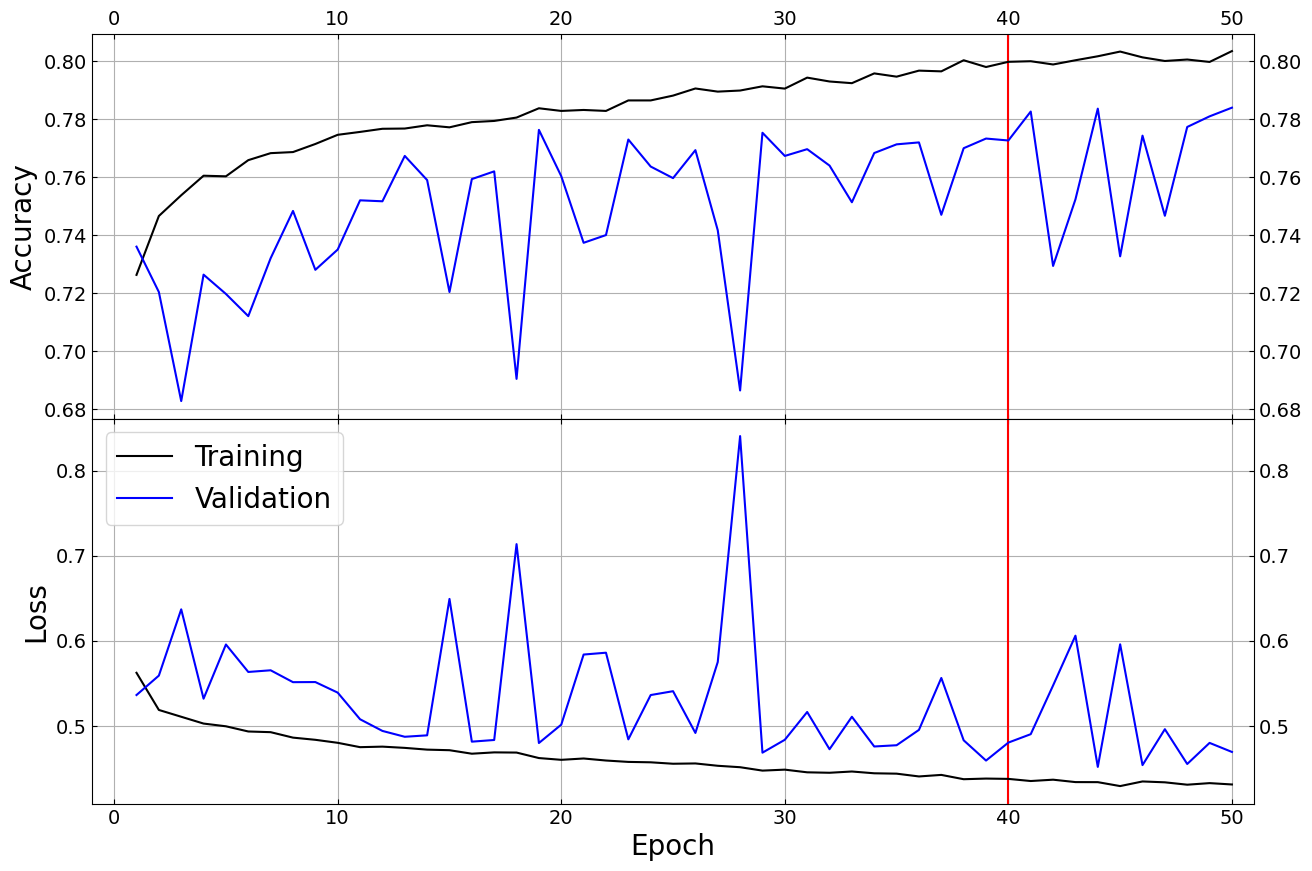

In [26]:
####RESULTS
# taking a look at how the training went
fig = plt.figure(figsize=(15,10))
gs = fig.add_gridspec(nrows=2, ncols=1, hspace=0)
axs = [fig.add_subplot(gs[0,0]), fig.add_subplot(gs[1,0])]
# axs = fig.subplots(nrows=2, ncols=1)

acc = hist.history['accuracy']
loss = hist.history['loss']
val_acc = hist.history['val_accuracy']
val_loss = hist.history['val_loss']

axs[0].plot(range(1,len(acc)+1), acc, c='k', zorder=5)
axs[1].plot(range(1,len(loss)+1), loss, c='k', zorder=5,
            label='Training')
axs[0].plot(range(1,len(val_acc)+1), val_acc, c='b', zorder=6)
axs[1].plot(range(1,len(val_loss)+1), val_loss, c='b', zorder=6,
            label='Validation')

axs[0].tick_params(labeltop=True)
axs[-1].set_xlabel('Epoch', size=20)
axs[0].set_ylabel('Accuracy', size=20)
axs[1].set_ylabel('Loss', size=20)

axs[1].legend(loc='upper left', fontsize=20).set_zorder(7)
for ax in axs:
    ax.set_ylim(*ax.get_ylim())
    ax.plot((len(acc)-10)*np.ones(2), ax.get_ylim(), c='r', zorder=3)
    ax.set_xticks(range(0,len(acc)+10, 10))
    ax.set_xlim(-1, len(acc)+1)
    ax.tick_params(labelsize=14, direction='in', right=True, top=True, labelright=True)
    ax.spines['top'].set_zorder(8)
    ax.grid(True, zorder=1)

In [27]:
print('  Training accuracy: %.3f' %acc[np.argmin(val_loss)])
print('Validation accuracy: %.3f' %val_acc[np.argmin(val_loss)])
print('\n  Training loss: %.3f' %loss[np.argmin(val_loss)])
print('Validation loss: %.3f' %val_loss[np.argmin(val_loss)])

  Training accuracy: 0.802
Validation accuracy: 0.784

  Training loss: 0.434
Validation loss: 0.452


  8/750 [..............................] - ETA: 5s 

2022-11-09 17:16:24.151496: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 720000000 exceeds 10% of free system memory.


94/94 [==============================] - 1s 7ms/step


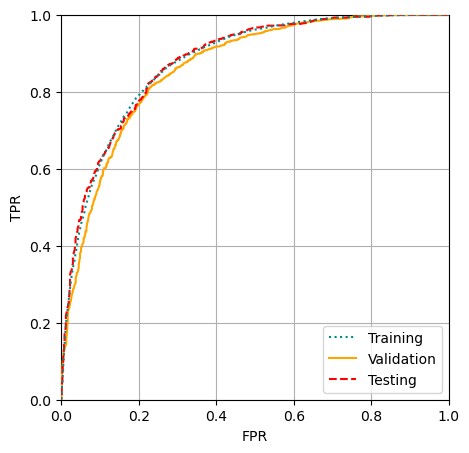

In [41]:
p_trn = model.predict(img_trn)[:,1] # converting back from the one-hot encoding
p_val = model.predict(img_val)[:,1]
p_tst = model.predict(img_tst)[:,1]

lab_trn = lab_trn[:,1]
lab_val = lab_val[:,1]
lab_tst = lab_tst[:,1]

fig = plt.figure(figsize=(5,5))
ax = fig.subplots(nrows=1, ncols=1)

thresholds = np.linspace(0,1,num=1000)

for pred, lab, c, ls, z, name in zip([p_trn,      p_val,        p_tst],   # predictions
                                     [lab_trn,    lab_val,      lab_tst], # labels
                                     ['darkcyan', 'orange',     'red'],   # colours
                                     [':',        '-',          '--'],    # linestyles
                                     [5,           3,           4],      # zorder...
                                     ['Training', 'Validation', 'Testing']):   
    
    tpr = np.array([np.sum(np.logical_and(pred > th, lab == 1)) for th in thresholds])/np.sum(lab)
    fpr = np.array([np.sum(np.logical_and(pred > th, lab == 0)) for th in thresholds])/(len(lab) - np.sum(lab))
    
    ax.plot(fpr, tpr, c=c, ls=ls, zorder=z, label=name)

    
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax.grid(True, zorder=1)
ax.legend(loc=4)

In [31]:
print(img_tst)

[[[[0.30054858 0.08036657 0.28845057]
   [0.30731687 0.04753608 0.25137135]
   [0.2948537  0.23061576 0.21205829]
   ...
   [0.35814136 0.23862657 0.25180796]
   [0.33249497 0.2843432  0.24406926]
   [0.34746864 0.20544253 0.12085433]]

  [[0.35295144 0.24199209 0.06633395]
   [0.34781662 0.16710597 0.2846117 ]
   [0.32876992 0.22160143 0.18631661]
   ...
   [0.36226466 0.13151756 0.16142757]
   [0.3318585  0.10482219 0.2834301 ]
   [0.39990157 0.2071205  0.23361917]]

  [[0.35922348 0.22893277 0.23693047]
   [0.32657385 0.18170585 0.12070769]
   [0.31994823 0.1850091  0.19870387]
   ...
   [0.3441117  0.20566146 0.2267843 ]
   [0.35086474 0.21407647 0.28857642]
   [0.3256885  0.22111683 0.23643848]]

  ...

  [[0.31968167 0.24247755 0.25606316]
   [0.35264397 0.23420821 0.18983753]
   [0.36369717 0.25357693 0.21498528]
   ...
   [0.348137   0.2508383  0.21074231]
   [0.29896373 0.2449997  0.17225732]
   [0.36563942 0.26318553 0.14236179]]

  [[0.34627438 0.2195133  0.3172699 ]
   [0.3

In [22]:
dist = np.sqrt(fpr**2 + (tpr-1)**2)
th_opt = thresholds[np.argmin(dist)]
print('The optimal threshold is %.3f' %th_opt)

The optimal threshold is 0.539


/opt/anaconda3/envs/astroconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in long_scalars
  if sys.path[0] == "":


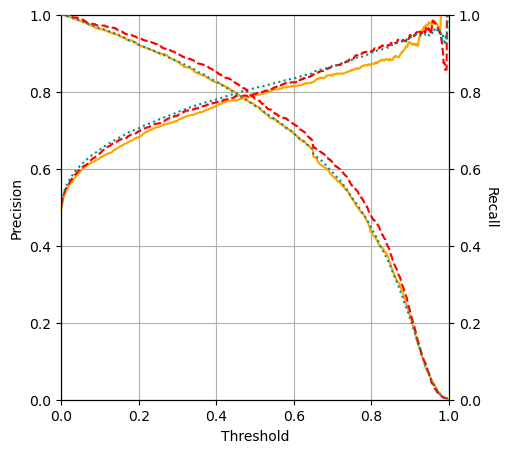

In [42]:
fig = plt.figure(figsize=(5,5))
axp = fig.subplots(nrows=1, ncols=1)
axr = axp.twinx()

for pred, lab, c, ls, z, name in zip([p_trn,      p_val,        p_tst],   # predictions
                                     [lab_trn,    lab_val,      lab_tst], # labels
                                     ['darkcyan', 'orange',     'red'],   # colours
                                     [':',        '-',          '--'],    # linestyles
                                     [5,           3,           4],       # zorder...
                                     ['Training', 'Validation', 'Testing']):   
    
    prec = np.array([np.sum(np.logical_and(pred > th, lab == 1))/np.sum(pred > th) for th in thresholds])
    rec  = np.array([np.sum(np.logical_and(pred > th, lab == 1)) for th in thresholds])/np.sum(lab)
    
    axp.plot(thresholds, prec, c=c, ls=ls, zorder=z, label=name)
    axr.plot(thresholds, rec,  c=c, ls=ls, zorder=z, label=name)
    
axp.set_xlim(0,1)
axp.set_ylim(0,1)
axr.set_ylim(0,1)
axp.set_xlabel('Threshold')
axp.set_ylabel('Precision')
axr.set_ylabel('Recall', rotation=270, va='baseline')

axp.grid(True, zorder=1)

In [46]:
f1 = 2*prec*rec/(prec+rec)
th_opt_f1 = thresholds[np.nanargmax(f1)]
print('The optimal threshold is %.3f' %th_opt_f1)

The optimal threshold is 0.320


In [47]:
# this function also comes from scikit-learn
conf_matrix = confusion_matrix(lab_tst, (p_tst > th_opt).astype(int), normalize='true')
print(conf_matrix)

NameError: name 'th_opt' is not defined

NameError: name 'conf_matrix' is not defined

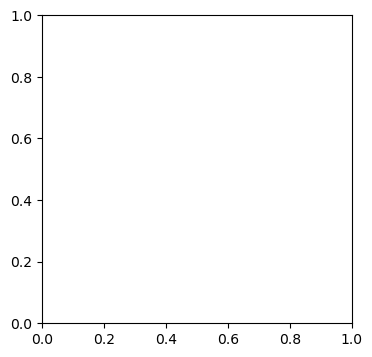

In [45]:
fig = plt.figure(figsize=(4,4))
ax = fig.subplots(nrows=1, ncols=1)
ax.imshow(conf_matrix, cmap='Blues')
for x,y in np.ndindex((2,2)):
    ax.text(x, y, '%.3f' %conf_matrix[y,x], 
            c=np.ones(3)*int(conf_matrix[y,x] > 0.5), ha='center', va='center', size=16)
    
ax.set_xlabel('Predicted label', size=16)
ax.set_xticks(ticks=range(2),
              labels=['nonmerger', 'merger'])
ax.set_ylabel('Predicted label', size=16)
ax.set_yticks(ticks=range(2),
              labels=['nonmerger', 'merger'],
              rotation=90, va='center')
ax.tick_params(labelsize=16)

In [34]:
for i in range(len(p_tst)):
    print(p_tst[i])
    print(tst_halos[0,i], tst_halos[1,i], '\n')

0.010293509
32176 35 

0.038680073
20040 28 

0.07173002
15687 29 

0.046256825
108770 32 

0.23782977
1054 29 

0.79050916
167182 49 

0.70563066
152864 38 

0.73677677
7497 32 

0.30512917
111832 44 

0.053751335
465606 31 

0.025222076
190415 32 

0.61527777
196766 35 

0.9397599
217434 28 

0.251149
267962 29 

0.85412633
92954 40 

0.011765351
391737 31 

0.86084133
167182 49 

0.31959876
155559 31 

0.10763203
104984 37 

0.26138023
90241 29 

0.072679214
237086 32 

0.8877838
21861 29 

0.04771517
79149 31 

0.75698453
269130 44 

0.85461324
116420 48 

0.79355866
177202 47 

0.9419228
117501 40 

0.15515448
195755 32 

0.64438325
327023 38 

0.8468726
229171 30 

0.85058874
113713 47 

0.9738604
233966 29 

0.09508556
353479 46 

0.14537756
165667 35 

0.18886812
218120 41 

0.09229861
186773 33 

0.9502932
95765 37 

0.77955693
2027 37 

0.6270791
72500 49 

0.6766366
90575 39 

0.21220759
221427 35 

0.097752236
144675 38 

0.22375596
315448 31 

0.6541143
86484 32 

0.376332